In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from seaborn import histplot
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [2]:
data = pd.read_csv(r'T:\toandangquoc\iuh_project_finals\data\data_train_model.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.fillna(0, inplace=True)

In [3]:
data.head()

,high,low,open,unix,cum_change,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,cma_7,month,atr,year,ppo,close
date,,,,,,,,,,,,,,,,,,
2020-01-02,209.789993,206.270004,206.750000,1577923200,0.045198,210.794776,209.779999,207.655221,209.779999,217.042583,227.120132,206.965034,211.514287,1,3.519989,2020,0.000000,209.779999
2020-01-03,210.399994,206.949997,207.210007,1578009600,0.090156,210.794776,209.224998,207.655221,209.631999,217.042583,227.120132,206.965034,211.514287,1,3.514990,2020,-0.042226,208.669998
2020-01-04,211.193329,206.806666,207.040003,1578096000,0.135397,210.888098,209.476666,208.065234,209.678399,217.042583,227.120132,206.965034,211.514287,1,3.577252,2020,-0.024991,209.980001
2020-01-05,211.986664,206.663335,206.870000,1578182400,0.180920,212.078555,209.930000,207.781446,209.893280,217.042583,227.120132,206.965034,211.514287,1,3.701972,2020,0.038602,211.290003
2020-01-06,212.779999,206.520004,206.699997,1578268800,0.226725,213.491436,210.464001,207.436567,210.254176,217.042583,227.120132,206.965034,211.514287,1,3.884688,2020,0.137642,212.600006


In [4]:
split_ratio=0.8
cut_off = int(len(data) * split_ratio)
train = data[:cut_off]
test = data[cut_off:]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
scaled_train = scaler.fit_transform(train)
print('Train shape:', scaled_train.shape)
scaled_test = scaler.fit_transform(test)
print('Test shape:', scaled_test.shape)
X_train = []
y_train = []
X_test = []
y_test = []
test_length = len(data) - cut_off
prediction_step = 50
for i in range(prediction_step, cut_off):
    X_train.append(scaled_train[i - prediction_step:i, 0:scaled_train.shape[1]])
    y_train.append(scaled_train[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

for i in range(prediction_step, test_length):
    X_test.append(scaled_test[i - prediction_step:i, 0:scaled_test.shape[1]])
    y_test.append(scaled_test[i, -1])
X_test, y_test = np.array(X_test), np.array(y_test)
y_test = np.reshape(y_test, (-1, 1))
        
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

Train shape: (1338, 18)
Test shape: (335, 18)
X_train shape : (1288, 50, 18)
y_train shape : (1288, 1)
X_test shape : (285, 50, 18)
y_test shape : (285, 1)


In [7]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 16)         │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,369 (17.07 KB)

 Trainable params: 4,369 (17.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_basic = regressor.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=64)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2651 - root_mean_squared_error: 0.5060 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2589
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0561 - root_mean_squared_error: 0.2365 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - root_mean_squared_error: 0.1640 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0178 - root_mean_squared_error: 0.1336 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss:

In [9]:
history_basic.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

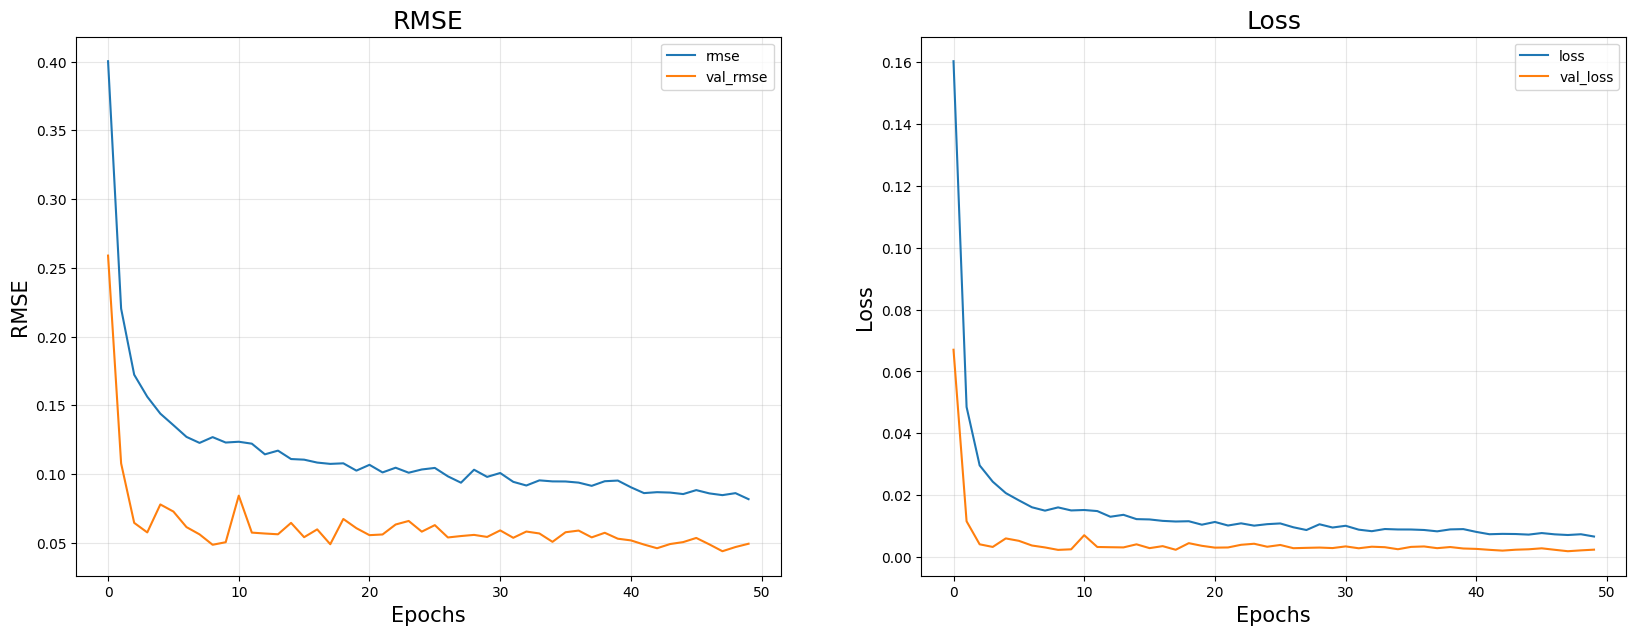

In [10]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history_basic.epoch, history_basic.history['root_mean_squared_error'], label = "rmse")
plt.plot(history_basic.epoch, history_basic.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history_basic.epoch, history_basic.history['loss'], label="loss")
plt.plot(history_basic.epoch, history_basic.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [11]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - root_mean_squared_error: 0.0665 
test loss, test acc: [0.0066 0.0814]


In [12]:
y_pred = regressor.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [13]:
prediction_copies = np.repeat(y_pred, test.shape[1], axis=-1)
lstm_pred = scaler.inverse_transform(prediction_copies)[:, -1]

In [14]:
true_copies = np.repeat(y_test, test.shape[1], axis=-1)
true = scaler.inverse_transform(true_copies)[:, 0]

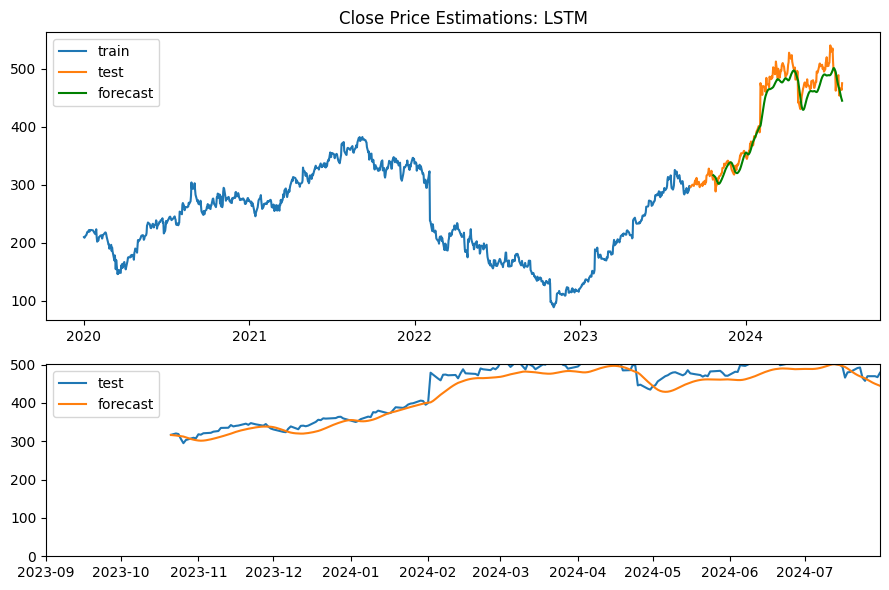

In [15]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(train['close'], label='train')
axes[0].plot(test['close'], linewidth=1.5, label='test')
axes[0].plot(test[prediction_step:].index, lstm_pred, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: LSTM')
axes[0].legend()

        # zoomed view
axes[1].plot(test[prediction_step:].index, true, linewidth=1.5, label='test')
axes[1].plot(test[prediction_step:].index, lstm_pred, label='forecast')
axes[1].set_xlim(test.index[0], test.index[-1]) 
axes[1].set_ylim(min(y_test.min(), lstm_pred.min()), max(y_test.max(), lstm_pred.max()))
axes[1].legend()

In [16]:
rmse = np.sqrt(mean_squared_error(true, lstm_pred))
r2 = r2_score(true, lstm_pred)
mae = mean_absolute_error(true, lstm_pred)
mape = mean_absolute_percentage_error(true, lstm_pred)

In [17]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 23.1474
R2: 0.8967
MAE: 19.0875
MAPE: 0.0423%


In [18]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = r'T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [19]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------


c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00596, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm.keras

Epoch 2: val_loss improved from 0.00596 to 0.00353, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm.keras

Epoch 3: val_loss improved from 0.00353 to 0.00345, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm.keras

Epoch 4: val_loss improved from 0.00345 to 0.00301, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm.keras

Epoch 5: val_loss did not improve from 0.00301

Epoch 6: val_loss did not improve from 0.00301

Epoch 7: val_loss did not improve from 0.00301

Epoch 8: val_loss did not improve from 0.00301

Epoch 9: val_loss did not improve from 0.00301
Epoch 9: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.0033827086444944143, 0.05816105753183365] and test accuracy: [0.008163217455148697, 0.09035052359104156]
-------------

In [20]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
4,False,False,False,32,16,0.2,"[0.0014263833872973919, 0.03776749223470688]","[0.003785256762057543, 0.061524439603090286]"
3,False,False,False,32,8,0.2,"[0.0013402174226939678, 0.0366089791059494]","[0.003927128855139017, 0.06266681104898453]"
2,False,False,False,16,32,0.2,"[0.002604544395580888, 0.05103473737835884]","[0.007403332740068436, 0.086042620241642]"
0,False,False,False,16,8,0.2,"[0.0033827086444944143, 0.05816105753183365]","[0.008163217455148697, 0.09035052359104156]"
1,False,False,False,16,16,0.2,"[0.0023212414234876633, 0.0481792651116848]","[0.01167371403425932, 0.10804495960474014]"
5,False,False,False,32,32,0.2,"[0.00277730287052691, 0.05270012095570564]","[0.01208100002259016, 0.10991360247135162]"


In [21]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 16
 dropout = 0.2
**************************
Results After Tunning:
 Test Set RMSE: 0.0615



In [22]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [23]:
n_neurons

32

In [24]:
regressor = Sequential()
regressor.add(LSTM(units=int(n_neurons), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=int(n_neurons), return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=int(n_neurons), return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=int(n_neurons), return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=int(n_neurons), return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = r'T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm_check.keras'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# callbacks=[es, mc]

history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[mc], verbose=0)

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00746, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm_check.keras

Epoch 2: val_loss improved from 0.00746 to 0.00462, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm_check.keras

Epoch 3: val_loss improved from 0.00462 to 0.00189, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm_check.keras

Epoch 4: val_loss did not improve from 0.00189

Epoch 5: val_loss did not improve from 0.00189

Epoch 6: val_loss improved from 0.00189 to 0.00182, saving model to T:\toandangquoc\iuh_project_finals\model_save\best_model_lstm_check.keras

Epoch 7: val_loss did not improve from 0.00182

Epoch 8: val_loss did not improve from 0.00182

Epoch 9: val_loss did not improve from 0.00182

Epoch 10: val_loss did not improve from 0.00182

Epoch 11: val_loss did not improve from 0.00182

Epoch 12: val_loss did not improve from 0.00182

Epoch 13: val_loss did not improve from 0.00

In [25]:
y_pred = regressor.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [26]:
prediction_copies = np.repeat(y_pred, test.shape[1], axis=-1)
lstm_pred = scaler.inverse_transform(prediction_copies)[:, -1]

In [27]:
true_copies = np.repeat(y_test, test.shape[1], axis=-1)
true = scaler.inverse_transform(true_copies)[:, 0]

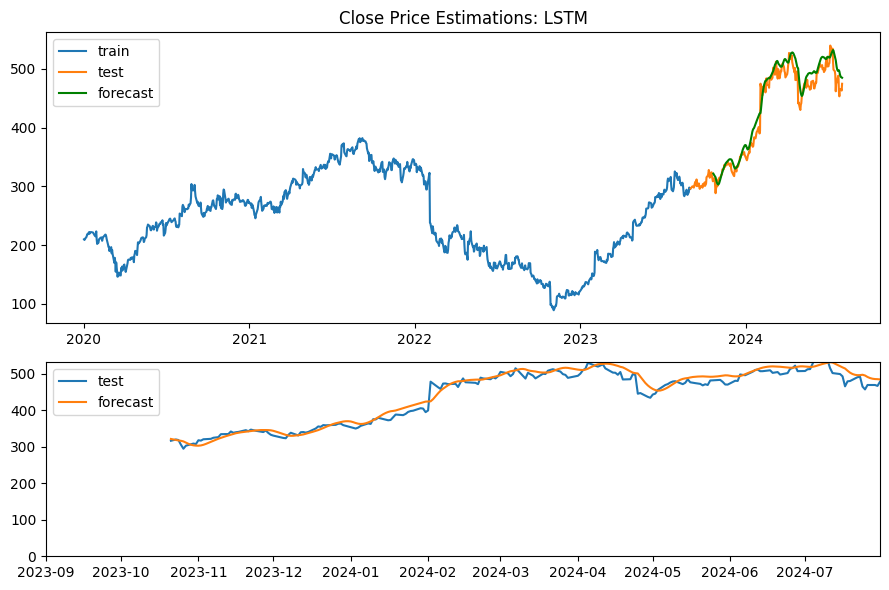

In [28]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(train['close'], label='train')
axes[0].plot(test['close'], linewidth=1.5, label='test')
axes[0].plot(test[prediction_step:].index, lstm_pred, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: LSTM')
axes[0].legend()

        # zoomed view
axes[1].plot(test[prediction_step:].index, true, linewidth=1.5, label='test')
axes[1].plot(test[prediction_step:].index, lstm_pred, label='forecast')
axes[1].set_xlim(test.index[0], test.index[-1]) 
axes[1].set_ylim(min(y_test.min(), lstm_pred.min()), max(y_test.max(), lstm_pred.max()))
axes[1].legend()

In [29]:
rmse = np.sqrt(mean_squared_error(true, lstm_pred))
r2 = r2_score(true, lstm_pred)
mae = mean_absolute_error(true, lstm_pred)
mape = mean_absolute_percentage_error(true, lstm_pred)

In [30]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 14.9781
R2: 0.9567
MAE: 11.5569
MAPE: 0.0263%


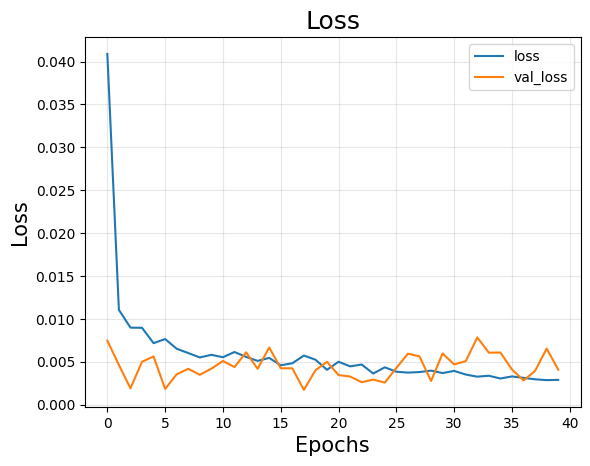

In [32]:
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
def cross_val_lstm(inputs, targets, X_train, k=6):
        '''
        Returns k-fold cross-validation score (RMSE) for LSTM.
        '''
        lstm_cv_scores = []
        kfold = KFold(n_splits=k, shuffle=False)
            
        fold_num = 1
        for train, test in kfold.split(inputs, targets):
            lstm_mod = get_lstm_model(X_train)
            
            print('-------------------------------------------------------------')
            print(f'Training for {fold_num}-fold:')
            
            lstm_mod.fit(
                x=inputs[train],
                y=targets[train],
                epochs=self.lstm_params['epochs'],
                batch_size=self.lstm_params['batch_size'],
                verbose=0)
            
            predictions = lstm_mod.predict(inputs[test], verbose=0)
            
            rmse = np.sqrt(((targets[test] - predictions)**2).mean())
            print('RMSE: {:.4f}'.format(rmse))
            lstm_cv_scores.append(rmse)
                
            # increase fold number
            fold_num = fold_num + 1
        return lstm_cv_scores